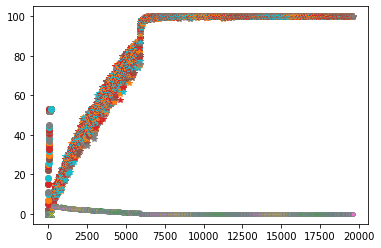

In [28]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
plt.ion()
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
from __future__ import print_function, division
# import moxing as mox
import os
import sys
import time
import torch
import torch.nn as nn
import torch.utils.data
from torch.optim import SGD
import torch.backends.cudnn as cudnn
import torch.utils.data.distributed as distributed
import torchvision
import logging

# os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15'
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
use_hvd = False
if use_hvd:
    import horovod.torch as hvd
    from horovod.torch.mpi_ops import allreduce_async
    hvd.init()
    torch.cuda.set_device(hvd.local_rank())

def create_logger(path):
    # set up logger
    if not os.path.exists(path):
        os.makedirs(path)

    log_file = 'log_{}.log'.format(time.strftime('%Y-%m-%d-%H-%M'))
    head = '%(asctime)-15s | %(filename)-10s | line %(lineno)-3d: %(message)s'
    logging.basicConfig(filename=os.path.join(path, log_file), format=head)
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    console = logging.StreamHandler()
    console.setLevel(logging.INFO)
    console.setFormatter(logging.Formatter(head))
    logger.addHandler(console)

    return logger

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

def plot_durations(x, y1, y2, mark):
    plt.plot(x, y1, mark[0])
    plt.plot(x, y2, mark[1])


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

class ResNetCifar(nn.Module):
    def __init__(self, num_classes, pretrained=None):
        super(ResNetCifar, self).__init__()
        self.num_classes = num_classes
        self.backbone = torchvision.models.resnet101()
        if pretrained:
            self.backbone.load_state_dict(torch.load(pretrained))
        self.backbone.fc = nn.Linear(2048, self.num_classes)
        nn.init.kaiming_normal_(self.backbone.fc.weight)
        nn.init.constant_(self.backbone.fc.bias, 0)

    def forward(self, x):
        x = self.backbone(x)
        return x

is_master = not use_hvd or (hvd.rank() == 0)
MILESTONES = [60, 120, 160]
base_batch_size = 128
batch_size = 512
epochs = 200
val_losses = []
val_top1 = []
    
def main():
    logger = create_logger('logs')
    
    normalize = torchvision.transforms.Normalize(mean=[0.5070751592371323, 0.48654887331495095, 0.4409178433670343], 
                                                 std=[0.2673342858792401, 0.2564384629170883, 0.27615047132568404])
    transform = torchvision.transforms.Compose([torchvision.transforms.RandomCrop(32, padding=4),
                                                torchvision.transforms.RandomHorizontalFlip(),
                                                torchvision.transforms.ToTensor(),
                                                normalize])
    
    train_dataset = torchvision.datasets.CIFAR100(root='./', transform=transform)
    if use_hvd:
        train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset, num_replicas=hvd.size(), rank=hvd.rank())
    else:
        train_sampler = torch.utils.data.RandomSampler(train_dataset)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=12)
    
    net = ResNetCifar(100, pretrained='resnet101-5d3b4d8f.pth')
#     logger.info(net)
    net.cuda()
    
    optimizer = SGD(net.parameters(), lr=0.1*batch_size/base_batch_size, momentum=0.9, weight_decay=0.0001)
    train_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=MILESTONES, gamma=0.2)
    if use_hvd:
        optimizer = hvd.DistributedOptimizer(optimizer, named_parameters=net.named_parameters())
    
        hvd.broadcast_parameters(net.state_dict(), root_rank=0)

    criterion = nn.CrossEntropyLoss().cuda()
#     losses = AverageMeter()
#     top1 = AverageMeter()
    losses = []
    top1 = []
    
    for epoch in range(epochs):
        val(net, logger)
        net.train()
        train_scheduler.step(epoch)
        for idx, (data, label) in enumerate(train_loader):
            data, label = data.cuda(), label.cuda()
            
            out = net(data)
            loss = criterion(out, label)

            prec = accuracy(out, label)[0]
            losses.append(loss.item())
            top1.append(prec.item())
#             losses.update(loss.item(), data.size(0))
#             top1.update(prec.item(), data.size(0))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
#             if idx % 20 == 0:
#                 logger.info(
#                     'rank: {}, epoch {}/{}, iterations {}/{}, Loss: {loss.val:.4f}({loss.avg:.4f}), '
#                     'Prec: {top1.val:.4f}%({top1.avg:.4f}%)'.format(hvd.rank() if use_hvd else 0, 
#                                                                     epoch, epochs, idx, 
#                                                                     len(train_loader), loss=losses, top1=top1))
            plot_durations(epoch*len(train_loader)+idx, loss.item(), prec.item(), ['.', '*'])
        plot_durations(epoch, val_losses[-1], val_top1[-1], ['x', 'o'])
#         if is_master and epoch % 10 == 0:
#             torch.save(net.state_dict(), 'models/{:04}_{:04}.pth'.format(epoch, epochs))

            
def val(net, logger=logging):
    normalize = torchvision.transforms.Normalize(mean=[0.5070751592371323, 0.48654887331495095, 0.4409178433670343], 
                                                 std=[0.2673342858792401, 0.2564384629170883, 0.27615047132568404])
    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                normalize])

    test_dataset = torchvision.datasets.CIFAR100(root='./', train=False, transform=transform)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False, num_workers=12)
    net.eval()
    net.cuda()
    criterion = nn.CrossEntropyLoss().cuda()
    prec = 0
    test_loss = 0
    for idx, (data, label) in enumerate(test_loader):
        data, label = data.cuda(), label.cuda()
        with torch.no_grad():
            out = net(data)
        loss = criterion(out, label)
        acc = accuracy(out, label)[0]
        test_loss += loss.cpu().item()
        _, preds = out.max(1)
        prec += preds.eq(label).cpu().sum()
    val_losses.append(test_loss/len(test_dataset))
    val_top1.append(prec*100/len(test_dataset))
#     logger.info('\n')
#     logger.info('Loss: {:.4f}, Prec: {:.4f}%'.format(test_loss*1./len(test_dataset), prec.item()*100./len(test_dataset)))
#     logger.info('\n')

main()

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import sys

sys.path.append('cache/models')
from resnet import resnet101


normalize = torchvision.transforms.Normalize(mean=[0.5070751592371323, 0.48654887331495095, 0.4409178433670343], 
                                                 std=[0.2673342858792401, 0.2564384629170883, 0.27615047132568404])
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            normalize])

test_dataset = torchvision.datasets.CIFAR100(root='./', train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=12)

class ResNetCifar(nn.Module):
    def __init__(self, num_classes, pretrained=None):
        super(ResNetCifar, self).__init__()
        self.num_classes = num_classes
        self.backbone = torchvision.models.resnet101()
        if pretrained:
            self.backbone.load_state_dict(torch.load(pretrained))
        self.backbone.fc = nn.Linear(2048, self.num_classes)
        nn.init.kaiming_normal_(self.backbone.fc.weight)
        nn.init.constant_(self.backbone.fc.bias, 0)

    def forward(self, x):
        x = self.backbone(x)
        return x

# net = ResNetCifar(100)
net = resnet101()
net.load_state_dict(torch.load('cache/checkpoint/resnet101/2019-08-30T15:59:31.101920/resnet101-187-best.pth'))
net = net.eval()

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

net = net.to('cuda:1')
criterion = nn.CrossEntropyLoss().to('cuda:1')
prec = 0
test_loss = 0
for idx, (data, label) in enumerate(test_loader):
    data, label = data.to('cuda:1'), label.to('cuda:1')
    with torch.no_grad():
        out = net(data)
    acc = accuracy(out, label)[0]
    loss = criterion(out, label)
    test_loss += loss.item()
    _, preds = out.max(1)
    prec += preds.eq(label).sum()
print('Loss: {:.4f}, prec: {:.4f}%'.format(test_loss*1./len(test_loader), prec.item()*100./len(test_dataset)))

Loss: 0.8962, prec: 78.9500%


In [1]:
# import moxing as mox
# mox.file.copy_parallel('../cifar100-train', 's3://bucket-8280/hejianzhong/cifar100-train')
import os
# os.environ['CUDA_VISIBLE_DEVICES']='0,1'
# print(os.environ)